**1.** Сгенерировать датасет при помощи sklearn.datasets.make_regression и обучить линейную модель при помощи градиентного и стохастического градиентного спуска. Нанести среднеквадратичную ошибку для обоих методов на один график, сделать выводы о разнице скорости сходимости каждого из методов.

**2.** Модифицировать решение первого задания путем добавления 𝐿2 -регуляризации (в функцию, считающую MSE, нужно добавить норму вектора весов) и сравнить результаты.

**3. [опция].** Модернизировать решение задания 2, заменив L2 регуляризацию на L1 регуляризацию.

-----


In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.datasets import make_regression

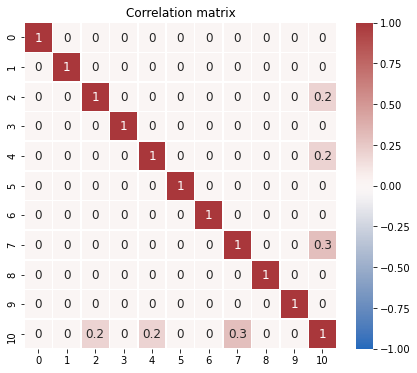

In [55]:
X, y = make_regression(n_samples=10000, n_features=10, noise=300, n_informative=6, random_state=6, bias=100)

plt.figure(figsize = (7,6))

corr_matrix = np.corrcoef(np.vstack((X.T, y)))
corr_matrix[np.abs(corr_matrix) < 0.1] = 0
corr_matrix = np.round(corr_matrix, 1)

sns.heatmap(corr_matrix, annot=True, linewidths=0.5, vmin=-1, vmax=1, cmap='vlag', annot_kws={"size":12})

plt.title('Correlation matrix')
plt.show()

In [102]:
def rmse(y, y_pred):
    '''
    Считает корень из среднеквадратичного отклонения двух последовательностей
    '''
    return ((y-y_pred)**2).mean()**0.5

def mae(y, y_pred):
    '''
    Считает средний модуль отклонений двух последовательностей
    '''
    return (np.abs(y-y_pred)).mean()

def lin_regression(
    X: np.array, y: np.array, bias=False,
    batch_size=100, step=1e-4, max_iter=1e5, n_inrow_steps=300, min_by='mse', verbose=1, reducing=0,
    regularization='None', lambda_=1):
    '''
    Считает коэффициенты линейной регрессии для вводимых признаков X (np.array) и целевой y (np.array).
    bias - флаг, определяющий, нужно ли добавлять постоянный член
    step - шаг обучения (leaning rate)
    max_iter - максимальное число шагов обучения
    n_inrow_steps - количество шагов без улучшения метрики, после которого обучение останавливается
    min_by (deprecated) - функция потерь, по которой производится минимазация ошибки
    verbose - для получения доп. инфо: 1 - в конце обучения; 2 - на каждом 10 шаге обучения
    reducing - коэффициент, сокращающий каждый следующий step. 0 говорит о том, что step остается неизменным.
    regularization - способ регуляризации модели. Доступные значения: 'L1', 'Lasso', 'L2', 'Ridge', 'None'.
    lambda_ - коэффициент регуляризации со значениями >=0. Проявляет эффект только с выбранным методом регуляризации.
    
    Возвращает кортеж из списка весов коэффициентов (np.array) и выбранную метрику на каждом 10 шаге (list) 
    '''
    if bias:
        X = np.vstack((np.ones_like(X[:, 0]), X.T)).T
    W = np.zeros_like(X[0])
    
    metrics = []
    iter_, metric_old, L = 1, np.inf, 0
    max_n_inrow_steps = 0
    step_inrow = 0
    n_batches = max(X.shape[0] / batch_size, 1)
    
    while iter_ < max_iter and step_inrow < n_inrow_steps:
        batch = np.random.randint(0, n_batches + 1)
#         batches = np.arange(n_batches, dtype='int')
#         np.random.shuffle(batches)
#         for batch in batches:
        X_b = X.copy()[batch * batch_size:(batch + 1) * batch_size]
        y_b = y.copy()[batch * batch_size:(batch + 1) * batch_size]
        W_old = W.copy()
        if min_by == 'mae':
            grad = np.dot(np.sign(np.dot(X_b, W) - y_b), X_b)
        elif min_by == 'mse':
            grad = 2 * np.dot((np.dot(X_b, W) - y_b), X_b)
        
        if regularization in ['L1', 'Lasso']:
            L = np.sign(W)
        elif regularization in ['L2', 'Ridge']:
            L = 2 * W
        grad += lambda_ * L
        W -= step / (iter_**reducing) * grad
        
        
        if min_by == 'mae':
            metric_new = mae(y, np.dot(X, W))
        elif min_by == 'mse':
            metric_new = rmse(y, np.dot(X, W))
        
        if step_inrow > max_n_inrow_steps:
                max_n_inrow_steps = step_inrow
                
        if metric_new > metric_old:
            step_inrow += 1
        else:
            step_inrow = 0
            metric_old = metric_new
        
        if not (iter_ - 1) % 10:
            if verbose > 1:
                print(iter_, metric_new, step_inrow, metric_old)
            metrics.append(metric_new)

        iter_ += 1
    if verbose:
        print(f'Metric: {metric_new}, iteration number: {iter_}')
    return W, metrics


Для начала можно проверить, как влияет в данном случае наличие свободного члена (при генерации без учета шума был равен 100):

In [120]:
W_mse_w_b, custom_mse_w_b = lin_regression(X, y, batch_size=1000, step=1e-5, verbose=1, bias=True)
W_mse_wo_b, custom_mse_wo_b = lin_regression(X, y, batch_size=1000, step=1e-5, verbose=1, bias=False)

Metric: 303.40562746534107, iteration number: 673
Metric: 319.03713291851443, iteration number: 703


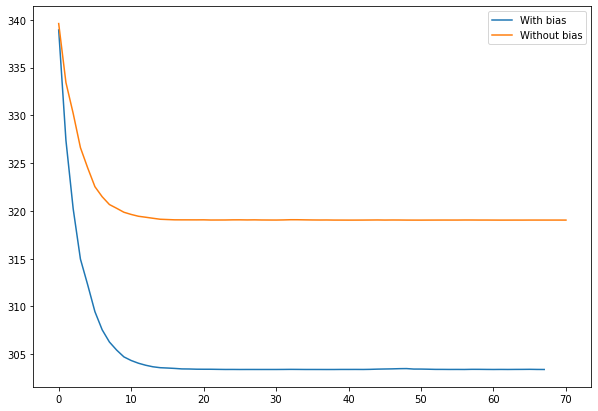

In [121]:
fig = plt.figure(figsize=(10, 7))
plt.plot(custom_mse_w_b, label='With bias')
plt.plot(custom_mse_wo_b ,label='Without bias')
plt.legend(loc='best')
plt.show()

Теперь рассмотрим разные размеры батчей и их зависимости на скорость и характер обучения (по *ox* отложено количество итераций * 10, а не эпох):

In [126]:
# a = []
a = lin_regression(X, y, batch_size=10, step=1e-5, verbose=1, bias=True)
a

Metric: 303.5052710394217, iteration number: 15068


(array([93.89666545,  0.54520025, 12.68644829, 52.88554022, 17.19505539,
        48.29232193, 23.77728918, -1.84137284, 81.50833959, -3.46983431,
         2.93898544]),
 [340.31170778336565,
  340.17256130349926,
  340.04876804333765,
  339.9295706318356,
  339.8070346835553,
  339.68395122067193,
  339.4700612738588,
  339.31354312918876,
  339.1924816847333,
  339.04741773542906,
  338.92783734259245,
  338.78383757587267,
  338.6370222172937,
  338.5148113455739,
  338.31830218697837,
  338.2516770776595,
  338.110827437058,
  337.9676701858951,
  337.8705856169009,
  337.77700189318966,
  337.66693256474565,
  337.511194162626,
  337.4031374318196,
  337.3146955103331,
  337.19768330662924,
  337.0732598425543,
  336.91347545084375,
  336.79664059303815,
  336.7248642362246,
  336.5980277079073,
  336.49200070136555,
  336.33324405585256,
  336.1890069964939,
  336.0650961345003,
  335.9387673933538,
  335.816402926941,
  335.65768218080126,
  335.4938482236505,
  335.3673044971401

In [133]:
batch_changes = {1: None, 10: None, 100: None, 1000: None}
for key in batch_changes.keys():
    print(f'Items in batch: {key}')
    batch_changes[key] = lin_regression(X, y, batch_size=key, step=1e-5, verbose=1, bias=True)
    print('----------------------')


Items in batch: 1
Metric: 305.1781875711256, iteration number: 78033
----------------------
Items in batch: 10
Metric: 303.5039232452412, iteration number: 14608
----------------------
Items in batch: 100
Metric: 303.42152276871025, iteration number: 2479
----------------------
Items in batch: 1000
Metric: 303.40890430842654, iteration number: 638
----------------------


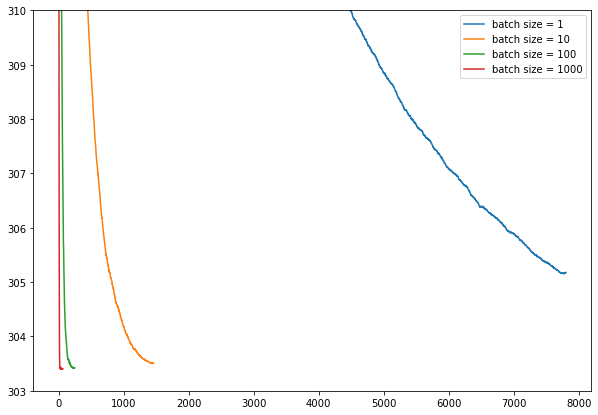

In [135]:
fig = plt.figure(figsize=(10, 7))
for key, value in batch_changes.items():
    plt.plot(value[1], label=f'batch size = {key}')
plt.legend(loc='best')
# plt.xscale('log')
plt.ylim(303, 310)
# plt.xlim(7000, 7600)
plt.show()

Как видно, при количестве элементов в батче модель получилась не такая стабильная и не находит того минимума, который достижим при значениях больше или равно 10. Таким образом пока самым эффективным выглядит вариант с количеством наблюдений в батче равным 10. Однако ситуацию с читым стохастическим градиентным спуском может исправить изменение максимального количества метрики без повышения:

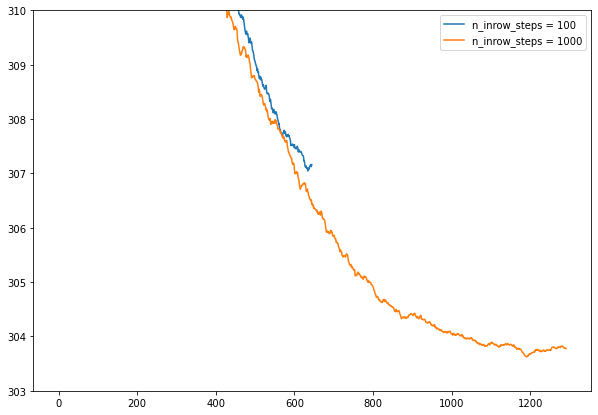

In [91]:
fig = plt.figure(figsize=(10, 7))
plt.plot(custom_mse_inrow_100, label='n_inrow_steps = 100')
plt.plot(custom_mse_inrow_1000 ,label='n_inrow_steps = 1000')
plt.legend(loc='best')
# plt.xscale('log')
plt.ylim(303, 310)
# plt.xlim(7000, 7600)
plt.show()

Ожидания подтвердились. Для стабилизации работы модели количество шагов без повышения метрики стоит увеличить при уменьшении количества элементов в батче датасета.

-----


Можно также сравнить, насколько сильно будут отличаться процессы изменения MSE при разных регуляризациях. Однако сильно повлиять на это они не должны:

In [136]:
print('L1 and L2 reg:')
W_mse_inrow_l1, custom_mse_inrow_l1 = lin_regression(X, y, bias=True, regularization='L1')
W_mse_inrow_l2, custom_mse_inrow_l2 = lin_regression(X, y, bias=True, regularization='L2')
print('\nWithout reg:')
W_mse_inrow_wo_reg, custom_mse_inrow_wo_reg = lin_regression(X, y, bias=True, regularization='None')

L1 and L2 reg:
Metric: 303.4340719319689, iteration number: 884
Metric: 303.56461206647094, iteration number: 602

Without reg:
Metric: 303.5232560289291, iteration number: 1054


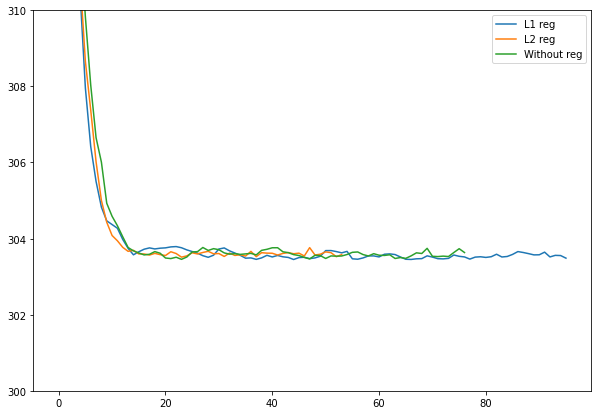

In [119]:
fig = plt.figure(figsize=(10, 7))
plt.plot(custom_mse_inrow_l1, label='L1 reg')
plt.plot(custom_mse_inrow_l2, label='L2 reg')
plt.plot(custom_mse_inrow_wo_reg ,label='Without reg')
plt.ylim(300, 310)
plt.legend(loc='best')
plt.show()

Как и ожидалось, графики не сильно отличаются. Вместо этого посмотрим на значения весов трех моделей. Если у исходной есть какие-то большие веса, они должны быть сглажены в моделях с регуляризацией:

In [116]:
W_mse_inrow_l2, W_mse_inrow_wo_reg

(array([96.06361837,  0.64878875, 10.57028734, 54.65939027, 18.00070765,
        44.67892746, 25.71583358,  0.84666907, 83.15569739, -0.87179761,
         3.66464399]),
 array([95.78859826,  0.38537923, 23.51330603, 54.97868424, 17.20671379,
        50.34474803, 26.72154071, -3.5763997 , 82.77435544, -8.22607529,
         4.76439523]))

Т.к. веса получились не слишком высокие, разницы не заметно

In [149]:
X_reg, y_reg = make_regression(n_samples=30, n_features=20, noise=300, n_informative=6, random_state=6, bias=100)

In [151]:
print('L1 and L2 reg:')
W_mse_inrow_l1, custom_mse_inrow_l1 = lin_regression(X_reg, y_reg, bias=True, regularization='L1')
W_mse_inrow_l2, custom_mse_inrow_l2 = lin_regression(X_reg, y_reg, bias=True, regularization='L2')
print('\nWithout reg:')
W_mse_inrow_wo_reg, custom_mse_inrow_wo_reg = lin_regression(X_reg, y_reg, bias=True, regularization='None')

L1 and L2 reg:
Metric: 214.081983623926, iteration number: 66135
Metric: 233.05059567613714, iteration number: 5465

Without reg:
Metric: 214.081148101423, iteration number: 100000


In [152]:
print('Without reg:')
print(W_mse_inrow_wo_reg)
print('---------')
print('With L1 reg:')
print(W_mse_inrow_l1)
print('---------')
print('With L2 reg:')
print(W_mse_inrow_l2)

Without reg:
[ 170.14091738  -60.36163384 -124.85180453 -115.40481873  119.26947201
  161.94733513  258.80682249   82.33981457  170.25481479  422.46020062
    4.85794745  -17.61427659 -262.17742328  -87.74078857  161.75499204
  -70.53179775  206.13445804  -24.74221273  194.86894679  -79.23199744
  -76.38917874]
---------
With L1 reg:
[ 169.78598822  -60.5702035  -124.90428639 -115.36822662  118.2764704
  161.05161449  256.81636423   81.69686673  169.78226694  421.67299535
    4.32717413  -17.33018277 -261.21430884  -87.88088795  161.78561675
  -70.22748272  205.8772663   -24.52374606  194.56577016  -79.06792841
  -76.02552721]
---------
With L2 reg:
[ 111.41768223  -78.41904582 -102.52919089  -90.42527936   29.71622245
   45.53027334   13.07811825    4.69836144  112.44993963  269.27190735
  -43.46564111    1.56822673 -128.35897952 -102.10346921  131.15532665
  -24.72364356  157.20166126   -3.67192492  145.68129179  -45.07773376
  -33.18780301]


Как видно, признак весом **422** после L2 регуляризации стал равным **269**, также видно снижения ряда других весов. При этом оптимизируемая метрика ухудшилась с **214.1** до **233**.